## 1.1 Image Preprocessing

In [1]:
import os
from PIL import Image
from tqdm import tqdm


In [39]:
image_dir = os.path.join("image")
output_dir = os.path.join(image_dir, "processed")
os.makedirs(output_dir, exist_ok=True)

# IMAGE SIZE
resize_size = (512, 512)


In [40]:
for file_name in tqdm(os.listdir(image_dir)):
    file_path = os.path.join(image_dir, file_name)

    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        try:
            img = Image.open(file_path).convert('RGB')  # 转为RGB
            img = img.resize(resize_size)

            base_name = os.path.splitext(file_name)[0]
            save_path = os.path.join(output_dir, f"{base_name}.jpg")
            img.save(save_path, "JPEG")
        except Exception as e:
            print(f"SKIP {file_name}: {e}")


100%|██████████| 21/21 [00:00<00:00, 103.20it/s]


## 1.2 Text Preprocessing

In [6]:
import sys
!"{sys.executable}" -m pip install pymupdf


In [7]:
import os
import fitz  # PyMuPDF
from tqdm import tqdm


In [8]:
pdf_dir = os.path.join("text")
output_dir = os.path.join(pdf_dir, "extracted_texts")
os.makedirs(output_dir, exist_ok=True)


In [38]:
for file_name in tqdm(os.listdir(pdf_dir)):
    if file_name.lower().endswith('.pdf'):
        pdf_path = os.path.join(pdf_dir, file_name)
        output_txt = os.path.join(output_dir, f"{os.path.splitext(file_name)[0]}.txt")

        try:
            doc = fitz.open(pdf_path)
            text = ""
            for page in doc:
                text += page.get_text()
            with open(output_txt, "w", encoding="utf-8") as f:
                f.write(text)
        except Exception as e:
            print(f"F: {file_name}, FR: {e}")


100%|██████████| 25/25 [00:04<00:00,  5.67it/s]


## 1.3 Video Preprocessing

In [10]:
import os
import cv2
from tqdm import tqdm


In [11]:
video_dir = os.path.join("video")
frame_output_dir = os.path.join(video_dir, "extracted_frames")
os.makedirs(frame_output_dir, exist_ok=True)

# timepoin of key frame
frame_interval_sec = 5


In [12]:
for file_name in tqdm(os.listdir(video_dir)):
    if file_name.lower().endswith(('.mp4', '.mov', '.avi', '.mkv')):
        video_path = os.path.join(video_dir, file_name)
        video_name = os.path.splitext(file_name)[0]
        save_dir = os.path.join(frame_output_dir, video_name)
        os.makedirs(save_dir, exist_ok=True)

        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        interval = int(fps * frame_interval_sec)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        frame_id = 0
        saved_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if frame_id % interval == 0:
                frame_path = os.path.join(save_dir, f"frame_{saved_count:04d}.jpg")
                cv2.imwrite(frame_path, frame)
                saved_count += 1
            frame_id += 1
        cap.release()


100%|██████████| 21/21 [00:20<00:00,  1.02it/s]


## 2 Data Vectorization

## 2.1 image:clip

In [13]:
!pip install torch torchvision
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to c:\users\rog\appdata\local\temp\pip-req-build-qhg426yh
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\ROG\AppData\Local\Temp\pip-req-build-qhg426yh'


In [14]:
import os
import torch
import clip
from PIL import Image
import numpy as np
from tqdm import tqdm


In [15]:
image_dir = os.path.join("image", "processed")
output_path = os.path.join(image_dir, "clip_image_features.npy")


In [16]:

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


In [17]:
features = []
file_names = []

for file_name in tqdm(sorted(os.listdir(image_dir))):
    if file_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join(image_dir, file_name)
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

        with torch.no_grad():
            feature = model.encode_image(image)
            feature = feature / feature.norm(dim=-1, keepdim=True) 
            features.append(feature.cpu().numpy())
            file_names.append(file_name)

features = np.vstack(features)


100%|██████████| 24/24 [00:00<00:00, 30.41it/s]


In [18]:
np.save(output_path, features)

with open(os.path.join(image_dir, "clip_image_filenames.txt"), "w") as f:
    for name in file_names:
        f.write(name + "\n")


## 2.2.1 Text:SBERT

In [24]:
import sys
!"{sys.executable}" -m pip install -U sentence-transformers


In [29]:
import os
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

text_dir = os.path.join("text", "extracted_texts")
output_path = os.path.join("text", "sbert_text_features.npy")



In [30]:
model = SentenceTransformer("all-MiniLM-L6-v2")  # 384


In [31]:
features = []
file_names = []

for file_name in tqdm(sorted(os.listdir(text_dir))):
    if file_name.endswith(".txt"):
        file_path = os.path.join(text_dir, file_name)
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read().strip()
        
        if len(text) == 0:
            continue

        embedding = model.encode(text)
        features.append(embedding)
        file_names.append(file_name)

features = np.vstack(features)


100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


In [32]:
np.save(os.path.join("text", "sbert_text_features.npy"), features)

with open(os.path.join("text", "sbert_text_filenames.txt"), "w", encoding="utf-8") as f:
    for name in file_names:
        f.write(name + "\n")


## 2.2.2 Text:TF-IDF

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import os
from tqdm import tqdm


In [34]:
text_dir = os.path.join("text", "extracted_texts")
output_path = os.path.join("text", "tfidf_text_features.npy")


In [35]:
documents = []
file_names = []

for file_name in tqdm(sorted(os.listdir(text_dir))):
    if file_name.lower().endswith(".txt"):
        file_path = os.path.join(text_dir, file_name)
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read().strip()
        if len(text) == 0:
            continue
        documents.append(text)
        file_names.append(file_name)


100%|██████████| 21/21 [00:00<00:00, 2066.79it/s]


In [36]:
vectorizer = TfidfVectorizer(
    stop_words="english", 
    max_features=3000      
)

tfidf_features = vectorizer.fit_transform(documents)


In [37]:
np.save(output_path, tfidf_features.toarray())

with open(os.path.join("text", "tfidf_text_filenames.txt"), "w", encoding="utf-8") as f:
    for name in file_names:
        f.write(name + "\n")

print("✅ ，shape：", tfidf_features.shape)


✅ ，shape： (20, 3000)


## 2.3.1 Video:Clip

In [74]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import clip  # Make sure it's installed: pip install git+https://github.com/openai/CLIP.git

# Root directory of all extracted frames
root_frame_dir = os.path.join("video", "extracted_frames")


In [75]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

print(f"✅ CLIP model loaded on {device}")


✅ CLIP model loaded on cuda


In [76]:
image_paths = []

for root, _, files in os.walk(root_frame_dir):
    for file in files:
        if file.lower().endswith(".jpg"):
            full_path = os.path.join(root, file)
            image_paths.append(full_path)

print(f"✅ Found {len(image_paths)} image files")


✅ Found 135 image files


In [77]:
features = []
filenames = []

for img_path in tqdm(image_paths):
    try:
        image = Image.open(img_path).convert("RGB")
        image_tensor = preprocess(image).unsqueeze(0).to(device)

        with torch.no_grad():
            embedding = model.encode_image(image_tensor).cpu().squeeze().numpy()

        features.append(embedding)

        # Save path relative to root_frame_dir
        relative_path = os.path.relpath(img_path, root_frame_dir)
        filenames.append(relative_path)

        print(f"✅ Processed: {relative_path}, shape: {embedding.shape}")

    except Exception as e:
        print(f"⚠️ Failed: {img_path}, reason: {e}")


  2%|▏         | 3/135 [00:00<00:06, 20.40it/s]

✅ Processed: frame-009835\frame_0000.jpg, shape: (512,)
✅ Processed: frame-009835\frame_0001.jpg, shape: (512,)
✅ Processed: frame-009835\frame_0002.jpg, shape: (512,)
✅ Processed: frame-009835\frame_0003.jpg, shape: (512,)
✅ Processed: frame-009835\frame_0004.jpg, shape: (512,)


 16%|█▌        | 21/135 [00:00<00:02, 53.65it/s]

✅ Processed: frame-009835\frame_0005.jpg, shape: (512,)
✅ Processed: frame-009835\frame_0006.jpg, shape: (512,)
✅ Processed: frame-014236\frame_0000.jpg, shape: (512,)
✅ Processed: frame-014236\frame_0001.jpg, shape: (512,)
✅ Processed: frame-014236\frame_0002.jpg, shape: (512,)
✅ Processed: frame-014236\frame_0003.jpg, shape: (512,)
✅ Processed: frame-014236\frame_0004.jpg, shape: (512,)
✅ Processed: frame-014236\frame_0005.jpg, shape: (512,)
✅ Processed: frame-015935\frame_0000.jpg, shape: (512,)
✅ Processed: frame-015935\frame_0001.jpg, shape: (512,)
✅ Processed: frame-015935\frame_0002.jpg, shape: (512,)
✅ Processed: frame-015935\frame_0003.jpg, shape: (512,)
✅ Processed: frame-021034\frame_0000.jpg, shape: (512,)
✅ Processed: frame-021034\frame_0001.jpg, shape: (512,)
✅ Processed: frame-021034\frame_0002.jpg, shape: (512,)
✅ Processed: frame-021034\frame_0003.jpg, shape: (512,)


 20%|██        | 27/135 [00:00<00:02, 53.49it/s]

✅ Processed: frame-021034\frame_0004.jpg, shape: (512,)
✅ Processed: frame-021034\frame_0005.jpg, shape: (512,)
✅ Processed: frame-021642\frame_0000.jpg, shape: (512,)
✅ Processed: frame-021642\frame_0001.jpg, shape: (512,)
✅ Processed: frame-021642\frame_0002.jpg, shape: (512,)
✅ Processed: frame-021642\frame_0003.jpg, shape: (512,)
✅ Processed: frame-021642\frame_0004.jpg, shape: (512,)
✅ Processed: frame-022319\frame_0000.jpg, shape: (512,)
✅ Processed: frame-022319\frame_0001.jpg, shape: (512,)
✅ Processed: frame-022319\frame_0002.jpg, shape: (512,)
✅ Processed: frame-022319\frame_0003.jpg, shape: (512,)
✅ Processed: frame-022319\frame_0004.jpg, shape: (512,)


 30%|██▉       | 40/135 [00:00<00:01, 56.05it/s]

✅ Processed: frame-028479\frame_0000.jpg, shape: (512,)
✅ Processed: frame-028479\frame_0001.jpg, shape: (512,)
✅ Processed: frame-028479\frame_0002.jpg, shape: (512,)
✅ Processed: frame-028479\frame_0003.jpg, shape: (512,)
✅ Processed: frame-028479\frame_0004.jpg, shape: (512,)
✅ Processed: frame-044589\frame_0000.jpg, shape: (512,)
✅ Processed: frame-044589\frame_0001.jpg, shape: (512,)
✅ Processed: frame-044589\frame_0002.jpg, shape: (512,)
✅ Processed: frame-044589\frame_0003.jpg, shape: (512,)
✅ Processed: frame-044589\frame_0004.jpg, shape: (512,)
✅ Processed: frame-046951\frame_0000.jpg, shape: (512,)
✅ Processed: frame-046951\frame_0001.jpg, shape: (512,)
✅ Processed: frame-046951\frame_0002.jpg, shape: (512,)
✅ Processed: frame-046951\frame_0003.jpg, shape: (512,)
✅ Processed: frame-046951\frame_0004.jpg, shape: (512,)


 42%|████▏     | 57/135 [00:01<00:01, 64.87it/s]

✅ Processed: frame-047074\frame_0000.jpg, shape: (512,)
✅ Processed: frame-047074\frame_0001.jpg, shape: (512,)
✅ Processed: frame-047074\frame_0002.jpg, shape: (512,)
✅ Processed: frame-047074\frame_0003.jpg, shape: (512,)
✅ Processed: frame-047074\frame_0004.jpg, shape: (512,)
✅ Processed: frame-047074\frame_0005.jpg, shape: (512,)
✅ Processed: frame-047433\frame_0000.jpg, shape: (512,)
✅ Processed: frame-047433\frame_0001.jpg, shape: (512,)
✅ Processed: frame-047433\frame_0002.jpg, shape: (512,)
✅ Processed: frame-047433\frame_0003.jpg, shape: (512,)
✅ Processed: frame-047433\frame_0004.jpg, shape: (512,)
✅ Processed: frame-047433\frame_0005.jpg, shape: (512,)
✅ Processed: frame-062673\frame_0000.jpg, shape: (512,)


 53%|█████▎    | 71/135 [00:01<00:01, 59.25it/s]

✅ Processed: frame-062673\frame_0001.jpg, shape: (512,)
✅ Processed: frame-062673\frame_0002.jpg, shape: (512,)
✅ Processed: frame-062673\frame_0003.jpg, shape: (512,)
✅ Processed: frame-062673\frame_0004.jpg, shape: (512,)
✅ Processed: frame-062673\frame_0005.jpg, shape: (512,)
✅ Processed: frame-062673\frame_0006.jpg, shape: (512,)
✅ Processed: frame-068866\frame_0000.jpg, shape: (512,)
✅ Processed: frame-068866\frame_0001.jpg, shape: (512,)
✅ Processed: frame-068866\frame_0002.jpg, shape: (512,)
✅ Processed: frame-068866\frame_0003.jpg, shape: (512,)
✅ Processed: frame-068866\frame_0004.jpg, shape: (512,)
✅ Processed: frame-069730\frame_0000.jpg, shape: (512,)


 63%|██████▎   | 85/135 [00:01<00:00, 62.46it/s]

✅ Processed: frame-069730\frame_0001.jpg, shape: (512,)
✅ Processed: frame-069730\frame_0002.jpg, shape: (512,)
✅ Processed: frame-069730\frame_0003.jpg, shape: (512,)
✅ Processed: frame-069730\frame_0004.jpg, shape: (512,)
✅ Processed: frame-069730\frame_0005.jpg, shape: (512,)
✅ Processed: frame-069730\frame_0006.jpg, shape: (512,)
✅ Processed: frame-069730\frame_0007.jpg, shape: (512,)
✅ Processed: frame-069730\frame_0008.jpg, shape: (512,)
✅ Processed: frame-069730\frame_0009.jpg, shape: (512,)
✅ Processed: frame-069730\frame_0010.jpg, shape: (512,)
✅ Processed: frame-070456\frame_0000.jpg, shape: (512,)
✅ Processed: frame-070456\frame_0001.jpg, shape: (512,)
✅ Processed: frame-070456\frame_0002.jpg, shape: (512,)
✅ Processed: frame-070456\frame_0003.jpg, shape: (512,)


 73%|███████▎  | 99/135 [00:01<00:00, 61.62it/s]

✅ Processed: frame-070456\frame_0004.jpg, shape: (512,)
✅ Processed: frame-070456\frame_0005.jpg, shape: (512,)
✅ Processed: frame-070456\frame_0006.jpg, shape: (512,)
✅ Processed: frame-070456\frame_0007.jpg, shape: (512,)
✅ Processed: frame-070456\frame_0008.jpg, shape: (512,)
✅ Processed: frame-070456\frame_0009.jpg, shape: (512,)
✅ Processed: frame-070456\frame_0010.jpg, shape: (512,)
✅ Processed: frame-070456\frame_0011.jpg, shape: (512,)
✅ Processed: frame-089915\frame_0000.jpg, shape: (512,)
✅ Processed: frame-089915\frame_0001.jpg, shape: (512,)
✅ Processed: frame-089915\frame_0002.jpg, shape: (512,)
✅ Processed: frame-089915\frame_0003.jpg, shape: (512,)


 79%|███████▊  | 106/135 [00:01<00:00, 62.36it/s]

✅ Processed: frame-089915\frame_0004.jpg, shape: (512,)
✅ Processed: frame-089915\frame_0005.jpg, shape: (512,)
✅ Processed: frame-116293\frame_0000.jpg, shape: (512,)
✅ Processed: frame-116293\frame_0001.jpg, shape: (512,)
✅ Processed: frame-116293\frame_0002.jpg, shape: (512,)
✅ Processed: frame-116293\frame_0003.jpg, shape: (512,)
✅ Processed: frame-116293\frame_0004.jpg, shape: (512,)
✅ Processed: frame-116293\frame_0005.jpg, shape: (512,)
✅ Processed: frame-116293\frame_0006.jpg, shape: (512,)
✅ Processed: frame-116293\frame_0007.jpg, shape: (512,)
✅ Processed: frame-116293\frame_0008.jpg, shape: (512,)
✅ Processed: frame-116293\frame_0009.jpg, shape: (512,)
✅ Processed: frame-119401\frame_0000.jpg, shape: (512,)
✅ Processed: frame-119401\frame_0001.jpg, shape: (512,)
✅ Processed: frame-119401\frame_0002.jpg, shape: (512,)


 91%|█████████ | 123/135 [00:02<00:00, 71.14it/s]

✅ Processed: frame-119401\frame_0003.jpg, shape: (512,)
✅ Processed: frame-119401\frame_0004.jpg, shape: (512,)
✅ Processed: frame-119401\frame_0005.jpg, shape: (512,)
✅ Processed: frame-119401\frame_0006.jpg, shape: (512,)
✅ Processed: frame-119401\frame_0007.jpg, shape: (512,)
✅ Processed: frame-119401\frame_0008.jpg, shape: (512,)
✅ Processed: frame-119401\frame_0009.jpg, shape: (512,)
✅ Processed: frame-119401\frame_0010.jpg, shape: (512,)
✅ Processed: frame-119401\frame_0011.jpg, shape: (512,)
✅ Processed: frame-119401\frame_0012.jpg, shape: (512,)
✅ Processed: frame-119781\frame_0000.jpg, shape: (512,)
✅ Processed: frame-119781\frame_0001.jpg, shape: (512,)
✅ Processed: frame-119781\frame_0002.jpg, shape: (512,)
✅ Processed: frame-119781\frame_0003.jpg, shape: (512,)


100%|██████████| 135/135 [00:02<00:00, 59.36it/s]

✅ Processed: frame-119781\frame_0004.jpg, shape: (512,)
✅ Processed: frame-119781\frame_0005.jpg, shape: (512,)
✅ Processed: frame-140709\frame_0000.jpg, shape: (512,)
✅ Processed: frame-140709\frame_0001.jpg, shape: (512,)
✅ Processed: frame-140709\frame_0002.jpg, shape: (512,)
✅ Processed: frame-140709\frame_0003.jpg, shape: (512,)
✅ Processed: frame-140709\frame_0004.jpg, shape: (512,)


In [78]:
if features:
    features = np.vstack(features)
    np.save(os.path.join(root_frame_dir, "clip_video_frame_features.npy"), features)

    with open(os.path.join(root_frame_dir, "clip_video_frame_filenames.txt"), "w", encoding="utf-8") as f:
        for name in filenames:
            f.write(name + "\n")

    print(f"✅ Saved {len(features)} CLIP features to clip_video_frame_features.npy")
else:
    print("❗ No CLIP features extracted.")


✅ Saved 135 CLIP features to clip_video_frame_features.npy


## 2.3.2 key frame-description（CLIP）(SBERT)

In [35]:
# subset_video_frames_by_folder_en.py
# ✅ Keep only frame_0000.jpg from each video folder and save a subset of CLIP and SBERT features.

import os
import numpy as np

# === Step 1: Define paths ===
base_path = "video/extracted_frames/"
all_frame_list_path = os.path.join(base_path, "clip_video_frame_filenames.txt")
clip_feature_path = os.path.join(base_path, "clip_video_frame_features.npy")
sbert_caption_path = "video/sbert_video_caption_features.npy"
sbert_caption_ids_path = "video/sbert_video_caption_ids.txt"

# === Step 2: Find frame_0000.jpg in each video folder ===
keep_filenames = []
for folder in sorted(os.listdir(base_path)):
    subdir = os.path.join(base_path, folder)
    if os.path.isdir(subdir):
        candidate = os.path.join(folder, "frame_0000.jpg")
        keep_filenames.append(candidate)

# === Step 3: Read all frame filenames and locate indices ===
with open(all_frame_list_path, "r", encoding="utf-8") as f:
    all_filenames = [line.strip() for line in f]

frame_idx_map = {name: i for i, name in enumerate(all_filenames)}
keep_indices = [frame_idx_map[name] for name in keep_filenames if name in frame_idx_map]

# === Step 4: Extract corresponding clip and SBERT feature subsets ===
clip_features = np.load(clip_feature_path)
sbert_features = np.load(sbert_caption_path)

clip_subset = clip_features[keep_indices]
sbert_subset = sbert_features[keep_indices]

# === Step 5: Save subset .npy and .txt files ===
os.makedirs("subset", exist_ok=True)

np.save("subset/clip_video_frame_features_subset.npy", clip_subset)
np.save("subset/sbert_video_caption_features_subset.npy", sbert_subset)

with open("subset/clip_video_frame_filenames_subset.txt", "w", encoding="utf-8") as f:
    for name in keep_filenames:
        f.write(name + "\n")

with open(sbert_caption_ids_path, "r", encoding="utf-8") as f:
    all_ids = [line.strip() for line in f]

with open("subset/sbert_video_caption_ids_subset.txt", "w", encoding="utf-8") as f:
    for i in keep_indices:
        f.write(all_ids[i] + "\n")

print(f"✅ Kept {len(keep_indices)} keyframes (one per video folder).")


✅ Kept 20 keyframes (one per video folder).


In [38]:
import clip
import torch
from PIL import Image
import os
import numpy as np
from collections import Counter
from tqdm import tqdm

# === Step 1: Load CLIP model ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# === Step 2: Use subset filenames (only 1 frame per video) ===
frame_root = "video/extracted_frames"
filename_txt = "subset/clip_video_frame_filenames_subset.txt"
output_txt = "subset/video_captions_generated.txt"

# === Step 3: Prompt list ===
prompts = [
    "A man playing basketball on a wooden court with a visible ceiling",
    "A cat walking across a tiled floor inside a room with furniture",
    "A dog running on grass near a stone wall",
    "A child playing indoors near a staircase",
    "A group of people in a classroom with chairs and a whiteboard",
    "A person speaking on camera in front of a backdrop with lights",
    "A person using a computer at a desk with bookshelves around",
    "A person walking in snow near a building entrance",
    "A person cooking in a kitchen with cabinets and a tiled wall",
    "A chef preparing food at a counter under bright ceiling lights",
    "A person holding a phone while standing near a bed",
    "A person sitting at a desk next to a window and a column",
    "A close-up of a human face with walls and artwork in the background",
    "A scenic landscape with trees and a distant cabin",
    "Night city with traffic lights and visible building facades",
    "A news reporter talking in a studio with lighting fixtures",
    "A street with moving cars and tall buildings on both sides",
    "A forest with sunlight shining through the leaves onto the ground",
    "A person giving a presentation in a room with a projector and seating",
    "People in a video conference with desks and monitors visible",
]

# === Step 4: Load frame paths ===
frame_map = {}
with open(filename_txt, 'r', encoding='utf-8') as f:
    for line in f:
        path = line.strip()
        video_id = path.split("/")[0]
        full_path = os.path.join(frame_root, path)
        frame_map[video_id] = full_path

# === Step 5: Encode prompts ===
with torch.no_grad():
    text_tokens = clip.tokenize(prompts).to(device)
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

# === Step 6: Generate caption per video ===
video_captions = {}

for vid, frame_path in tqdm(frame_map.items(), desc="Generating captions"):
    try:
        image = preprocess(Image.open(frame_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            img_feature = model.encode_image(image).float()
        img_feature /= img_feature.norm(dim=-1, keepdim=True)
        sim = img_feature @ text_features.T
        best_idx = sim.argmax().item()
        caption = prompts[best_idx]
        video_captions[vid] = caption
    except:
        print(f"⚠️ Failed to load: {frame_path}")
        video_captions[vid] = "[Unrecognized content]"

# === Step 7: Save captions ===
with open(output_txt, "w", encoding="utf-8") as f:
    for vid in sorted(video_captions):
        f.write(f"{vid}: {video_captions[vid]}\n")

print(f"✅ Captions saved to {output_txt}")

Generating captions:  33%|███▎      | 7/21 [00:00<00:00, 63.81it/s]

⚠️ Failed to load: video/extracted_frames\.ipynb_checkpoints\frame_0000.jpg


Generating captions: 100%|██████████| 21/21 [00:00<00:00, 68.56it/s]

✅ Captions saved to subset/video_captions_generated.txt


In [42]:
from sentence_transformers import SentenceTransformer
import numpy as np
import os

# Step 1: Load subset video captions
caption_txt = "subset/video_captions_generated.txt"
captions = []
video_ids = []

with open(caption_txt, "r", encoding="utf-8") as f:
    for line in f:
        if ": " in line:
            vid, cap = line.strip().split(": ", 1)
            video_ids.append(vid)
            captions.append(cap)

# Step 2: SBERT encoding
print("🔄 Encoding subset captions with SBERT...")
model = SentenceTransformer("all-MiniLM-L6-v2")
features = model.encode(captions, normalize_embeddings=True)

# Step 3: Save vectors and IDs to subset/
os.makedirs("subset", exist_ok=True)
np.save("subset/sbert_video_caption_features_subset.npy", features)
with open("subset/sbert_video_caption_ids_subset.txt", "w", encoding="utf-8") as f:
    for vid in video_ids:
        f.write(vid + "\n")

print("✅ Saved:")
print(" - subset/sbert_video_caption_features_subset.npy")
print(" - subset/sbert_video_caption_ids_subset.txt")


🔄 Encoding subset captions with SBERT...
✅ Saved:
 - subset/sbert_video_caption_features_subset.npy
 - subset/sbert_video_caption_ids_subset.txt


## 2.4 Vectorisation Comparison:TF-IDF VS SBERT

In [12]:
# vectorisation_comparison.py
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random

# === Step 1: Simulated short texts for comparison ===
texts = [
    "A man is sitting at a desk typing on a laptop.",
    "A woman is walking her dog in the park.",
    "Children are playing soccer on a grassy field.",
    "An old man is reading a newspaper on a bench.",
    "A person is cooking in a bright kitchen.",
    "Two people are talking in a cafe.",
    "A cyclist is riding down a mountain trail.",
    "A dog is running through the water.",
    "Someone is playing guitar on a stage.",
    "A man is presenting in front of a whiteboard.",
    "A group is dancing at a concert.",
    "A woman is painting on a canvas.",
    "A baby is crawling across the floor.",
    "An athlete is lifting weights in a gym.",
    "Someone is watering plants in a garden.",
    "A person is kayaking on a lake.",
    "A child is drawing with crayons.",
    "People are eating dinner at a restaurant.",
    "A teacher is speaking to students in a classroom.",
    "Two men are playing chess at a table."
]

# === Step 2: Vectorise using SBERT ===
sbert_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
sbert_vectors = sbert_model.encode(texts, normalize_embeddings=True)

# === Step 3: Vectorise using TF-IDF ===
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_vectors = tfidf.fit_transform(texts).toarray()

# === Step 4: Pick a random query and compute similarities ===
query_idx = random.randint(0, len(texts)-1)
query_text = texts[query_idx]

print(f"\n🔍 Query text ({query_idx}):\n{query_text}\n")

# SBERT similarity
sim_sbert = cosine_similarity(sbert_vectors[query_idx:query_idx+1], sbert_vectors)[0]
top_sbert = np.argsort(sim_sbert)[-6:][::-1]

# TF-IDF similarity
sim_tfidf = cosine_similarity(tfidf_vectors[query_idx:query_idx+1], tfidf_vectors)[0]
top_tfidf = np.argsort(sim_tfidf)[-6:][::-1]

# === Step 5: Show results ===
print("✅ Top 5 matches using SBERT:")
for i in top_sbert[1:]:
    print(f"[{i}] Score: {sim_sbert[i]:.4f}\n{texts[i]}\n")

print("✅ Top 5 matches using TF-IDF:")
for i in top_tfidf[1:]:
    print(f"[{i}] Score: {sim_tfidf[i]:.4f}\n{texts[i]}\n")


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

e:\anaconda3\envs\sam-env\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ROG\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


🔍 Query text (14):
Someone is watering plants in a garden.

✅ Top 5 matches using SBERT:
[4] Score: 0.2360
A person is cooking in a bright kitchen.

[15] Score: 0.2344
A person is kayaking on a lake.

[1] Score: 0.2291
A woman is walking her dog in the park.

[6] Score: 0.1458
A cyclist is riding down a mountain trail.

[11] Score: 0.1443
A woman is painting on a canvas.

✅ Top 5 matches using TF-IDF:
[19] Score: 0.0000
Two men are playing chess at a table.

[8] Score: 0.0000
Someone is playing guitar on a stage.

[1] Score: 0.0000
A woman is walking her dog in the park.

[2] Score: 0.0000
Children are playing soccer on a grassy field.

[3] Score: 0.0000
An old man is reading a newspaper on a bench.



## 3.SOM

## 3.1 Image domain (clip)：image + key frame & QE/TE

Data scaling took: 0.000170 seconds.
SOM training took: 0.000010 seconds.
Projecting on SOM took: 0.000034 seconds.
Projecting on SOM took: 0.000014 seconds.
Projecting on SOM took: 0.000010 seconds.
Projecting on SOM took: 0.000008 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000017 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Pr

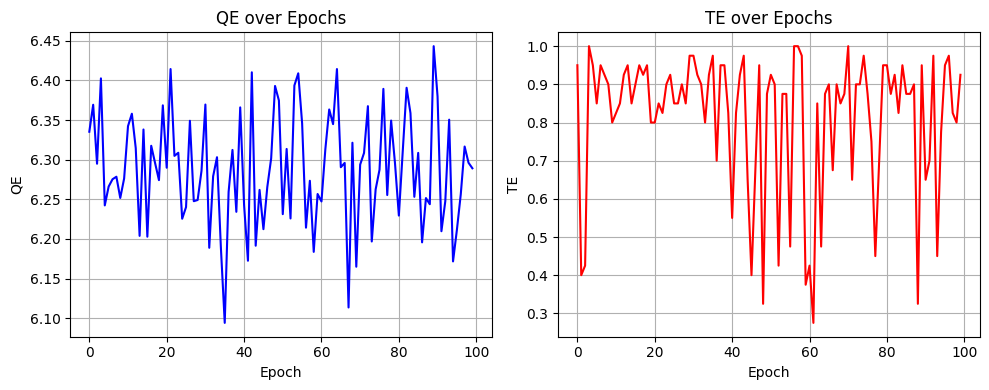

In [73]:
# train_clip_som_with_qe_te.py
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numbasom import SOM, project_on_lattice
from scipy.spatial.distance import cdist

# === Step 1: Load CLIP features (image + frame)
image_features = np.load("image/processed/clip_image_features.npy").astype(np.float32)
frame_features = np.load("subset/clip_video_frame_features_subset.npy").astype(np.float32)
combined = np.concatenate([image_features, frame_features], axis=0)

# === Step 2: PCA to 30 dimensions
pca = PCA(n_components=30)
combined_pca = pca.fit_transform(combined)

# === Step 3: Initialize SOM (4x4)
som = SOM(som_size=(4, 4), is_torus=False)

# === Step 4: Train SOM with QE/TE tracking
num_epochs = 100
qe_list, te_list, lattice_list = [], [], []

for epoch in range(num_epochs):
    lattice = som.train(combined_pca, num_iterations=1, normalize=True)
    lattice_list.append(np.copy(lattice))

    # === Quantization Error (QE)
    qe_total = 0
    for vec in combined_pca:
        proj = project_on_lattice(vec.reshape(1, -1), lattice)
        bmu_coord = [k for k, v in proj.items() if v][0]
        bmu_vec = lattice[bmu_coord]
        qe_total += np.linalg.norm(vec - bmu_vec)
    qe_list.append(qe_total / len(combined_pca))

    # === Topographic Error (TE)
    te_count = 0
    for vec in combined_pca:
        dists = cdist([vec], lattice.reshape(-1, lattice.shape[-1]))[0]
        bmu1, bmu2 = np.argsort(dists)[:2]
        coord1 = np.unravel_index(bmu1, lattice.shape[:2])
        coord2 = np.unravel_index(bmu2, lattice.shape[:2])
        if abs(coord1[0] - coord2[0]) + abs(coord1[1] - coord2[1]) > 1:
            te_count += 1
    te_list.append(te_count / len(combined_pca))

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1:3d}: QE = {qe_list[-1]:.4f}, TE = {te_list[-1]:.4f}")

# === Step 5: Save results
os.makedirs("SOM", exist_ok=True)
np.save("SOM/clip_qe_list.npy", qe_list)
np.save("SOM/clip_te_list.npy", te_list)
np.save("SOM/clip_lattice_list.npy", np.array(lattice_list))

best_idx = int(np.argmin(qe_list))
np.save("SOM/clip_som_lattice_best.npy", lattice_list[best_idx])
print(f"✅ Best lattice: Epoch {best_idx+1}, QE = {qe_list[best_idx]:.4f}")

# === Step 6: Plot QE/TE curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(qe_list, label="Quantization Error", color="blue")
plt.xlabel("Epoch")
plt.ylabel("QE")
plt.title("QE over Epochs")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(te_list, label="Topographic Error", color="red")
plt.xlabel("Epoch")
plt.ylabel("TE")
plt.title("TE over Epochs")
plt.grid(True)

plt.tight_layout()
plt.savefig("SOM/qe_te_clip.png")
print("✅ Saved QE/TE curves and best SOM to SOM/")


##
   Epoch 100: QE = 6.2892, TE = 0.9250
   Best lattice: Epoch 36, QE = 6.0941

![QE / TE for SBERT-SOM](SOM/qe_te_clip.png)

## 3.2 Text domain (SBERT)_: text + video description & QE/TE

Data scaling took: 0.000151 seconds.
SOM training took: 0.000011 seconds.
Projecting on SOM took: 0.173159 seconds.
Projecting on SOM took: 0.000016 seconds.
Projecting on SOM took: 0.000010 seconds.
Projecting on SOM took: 0.000010 seconds.
Projecting on SOM took: 0.000009 seconds.
Projecting on SOM took: 0.000009 seconds.
Projecting on SOM took: 0.000008 seconds.
Projecting on SOM took: 0.000008 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000006 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000006 seconds.
Projecting on SOM took: 0.000006 seconds.
Projecting on SOM took: 0.000008 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000006 seconds.
Projecting on SOM took: 0.000007 seconds.
Projecting on SOM took: 0.000007 seconds.
Pr

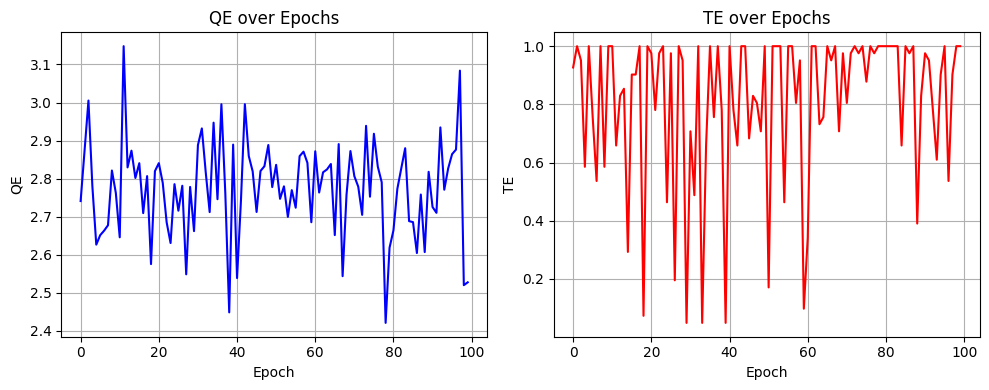

In [74]:
# train_sbert_som_with_qe_te.py
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numbasom import SOM, project_on_lattice
from scipy.spatial.distance import cdist

# === Step 1: Load SBERT features (caption + text)
caption_features = np.load("subset/sbert_video_caption_features_subset.npy").astype(np.float32)
text_features = np.load("text/sbert_text_features.npy").astype(np.float32)
combined = np.concatenate([caption_features, text_features], axis=0)

# === Step 2: PCA to 30 dimensions
pca = PCA(n_components=30)
combined_pca = pca.fit_transform(combined)

# === Step 3: Initialize SOM (4x4)
som = SOM(som_size=(4, 4), is_torus=False)

# === Step 4: Train SOM with QE/TE tracking
num_epochs = 100
qe_list, te_list, lattice_list = [], [], []

for epoch in range(num_epochs):
    lattice = som.train(combined_pca, num_iterations=1, normalize=True)
    lattice_list.append(np.copy(lattice))

    # === Quantization Error (QE)
    qe_total = 0
    for vec in combined_pca:
        proj = project_on_lattice(vec.reshape(1, -1), lattice)
        bmu_coord = [k for k, v in proj.items() if v][0]
        bmu_vec = lattice[bmu_coord]
        qe_total += np.linalg.norm(vec - bmu_vec)
    qe_list.append(qe_total / len(combined_pca))

    # === Topographic Error (TE)
    te_count = 0
    for vec in combined_pca:
        dists = cdist([vec], lattice.reshape(-1, lattice.shape[-1]))[0]
        bmu1, bmu2 = np.argsort(dists)[:2]
        coord1 = np.unravel_index(bmu1, lattice.shape[:2])
        coord2 = np.unravel_index(bmu2, lattice.shape[:2])
        if abs(coord1[0] - coord2[0]) + abs(coord1[1] - coord2[1]) > 1:
            te_count += 1
    te_list.append(te_count / len(combined_pca))

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1:3d}: QE = {qe_list[-1]:.4f}, TE = {te_list[-1]:.4f}")

# === Step 5: Save outputs
os.makedirs("SOM", exist_ok=True)
np.save("SOM/sbert_qe_list.npy", qe_list)
np.save("SOM/sbert_te_list.npy", te_list)
np.save("SOM/sbert_lattice_list.npy", np.array(lattice_list))

best_idx = int(np.argmin(qe_list))
np.save("SOM/sbert_som_lattice_best.npy", lattice_list[best_idx])
print(f"✅ Best lattice: Epoch {best_idx+1}, QE = {qe_list[best_idx]:.4f}")

# === Step 6: Plot QE/TE curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(qe_list, label="Quantization Error", color="blue")
plt.xlabel("Epoch")
plt.ylabel("QE")
plt.title("QE over Epochs")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(te_list, label="Topographic Error", color="red")
plt.xlabel("Epoch")
plt.ylabel("TE")
plt.title("TE over Epochs")
plt.grid(True)

plt.tight_layout()
plt.savefig("SOM/qe_te_sbert.png")
print("✅ Saved QE/TE curves and best SOM to SOM/")


## 
   Epoch 100: QE = 2.5277, TE = 1.0000
   Best lattice: Epoch 79, QE = 2.4211
   

![QE / TE for SBERT-SOM](SOM/qe_te_sbert.png)


## 3.3 PCA-RGB

## 3.3.1 Image domain

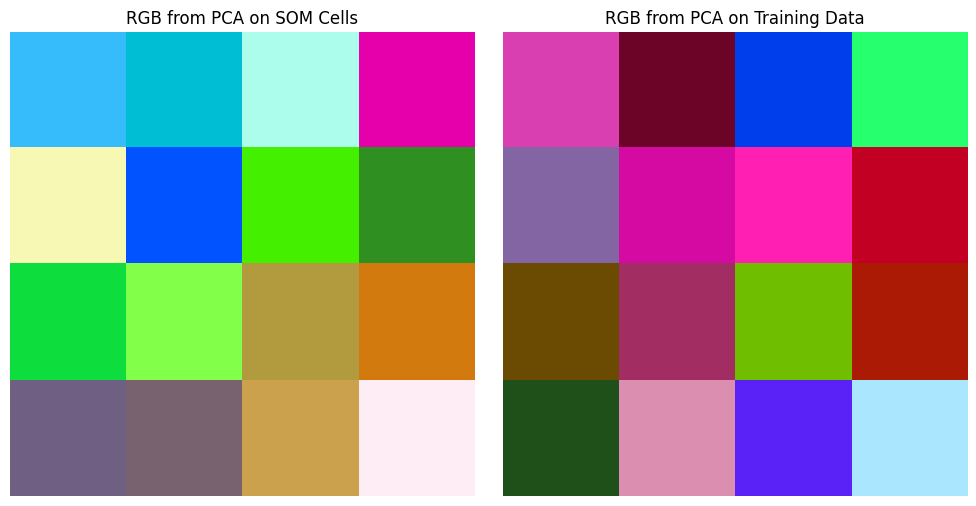

✅ Saved: SOM/clip_som_rgb_comparison.png


In [77]:
# plot_som_rgb_comparison.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os

# === Step 1: Load SOM and training data ===
lattice = np.load("SOM/clip_som_lattice_best.npy")  # shape (H, W, 30)
img_feat = np.load("image/processed/clip_image_features.npy")
frame_feat = np.load("subset/clip_video_frame_features_subset.npy")
features = np.concatenate([img_feat, frame_feat], axis=0)

# === Step 2: PCA-30 same as used in SOM training
pca_30 = PCA(n_components=30).fit(features)
features_30 = pca_30.transform(features)
flat_lattice = lattice.reshape(-1, lattice.shape[-1])  # shape: (H*W, 30)

# === Method A: PCA on SOM lattice itself
pca_a = PCA(n_components=3).fit(flat_lattice)
rgb_a = pca_a.transform(flat_lattice)
rgb_a -= rgb_a.min(0)
rgb_a /= rgb_a.max(0)
rgb_a = rgb_a.reshape(lattice.shape[0], lattice.shape[1], 3)

# === Method B: PCA on features_30, then apply to lattice
pca_b = PCA(n_components=3).fit(features_30)
rgb_b = pca_b.transform(flat_lattice)
rgb_b -= rgb_b.min(0)
rgb_b /= rgb_b.max(0)
rgb_b = rgb_b.reshape(lattice.shape[0], lattice.shape[1], 3)

# === Step 4: Plot and save
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(rgb_a)
plt.title("RGB from PCA on SOM Cells")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rgb_b)
plt.title("RGB from PCA on Training Data")
plt.axis("off")

plt.tight_layout()
os.makedirs("SOM", exist_ok=True)
plt.savefig("SOM/clip_som_rgb_comparison.png")
plt.show()

print("✅ Saved: SOM/clip_som_rgb_comparison.png")


![PCA for CLIP-SOM](SOM/clip_som_rgb_comparison.png)


## 3.3.2 Text domain

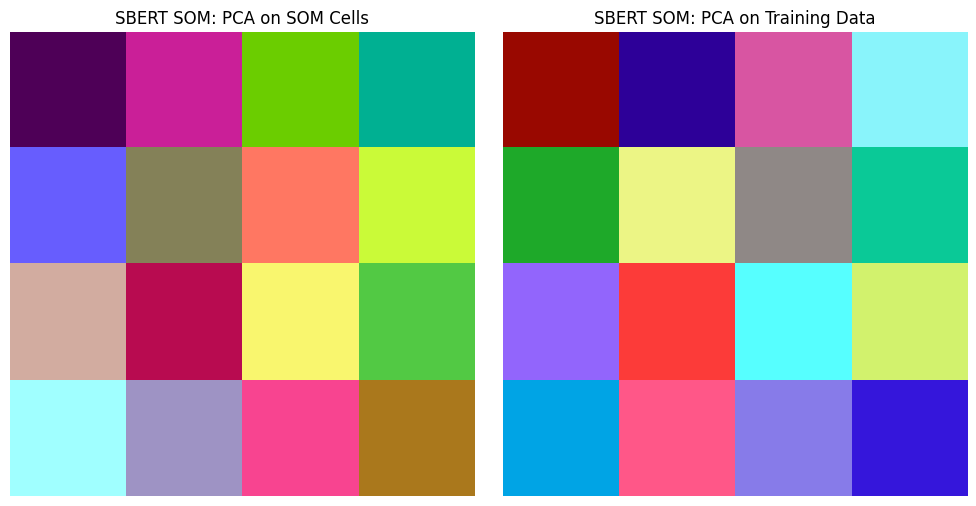

✅ Saved: SOM/sbert_som_rgb_comparison.png


In [79]:
# plot_sbert_som_rgb_comparison.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os

# === Step 1: Load SBERT SOM and training data ===
lattice = np.load("SOM/sbert_som_lattice_best.npy")  # shape (H, W, 30)
caption_features = np.load("subset/sbert_video_caption_features_subset.npy")
text_features = np.load("text/sbert_text_features.npy")
features = np.concatenate([caption_features, text_features], axis=0)

# === Step 2: PCA-30 same as used in SOM training
pca_30 = PCA(n_components=30).fit(features)
features_30 = pca_30.transform(features)
flat_lattice = lattice.reshape(-1, lattice.shape[-1])  # shape: (H*W, 30)

# === Method A: PCA on SOM lattice itself
pca_a = PCA(n_components=3).fit(flat_lattice)
rgb_a = pca_a.transform(flat_lattice)
rgb_a -= rgb_a.min(0)
rgb_a /= rgb_a.max(0)
rgb_a = rgb_a.reshape(lattice.shape[0], lattice.shape[1], 3)

# === Method B: PCA on training data, apply to lattice
pca_b = PCA(n_components=3).fit(features_30)
rgb_b = pca_b.transform(flat_lattice)
rgb_b -= rgb_b.min(0)
rgb_b /= rgb_b.max(0)
rgb_b = rgb_b.reshape(lattice.shape[0], lattice.shape[1], 3)

# === Step 4: Plot side-by-side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(rgb_a)
plt.title("SBERT SOM: PCA on SOM Cells")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rgb_b)
plt.title("SBERT SOM: PCA on Training Data")
plt.axis("off")

plt.tight_layout()
os.makedirs("SOM", exist_ok=True)
plt.savefig("SOM/sbert_som_rgb_comparison.png")
plt.show()

print("✅ Saved: SOM/sbert_som_rgb_comparison.png")


![PCA for SBERT-SOM](SOM/sbert_som_rgb_comparison.png)


## 4.Mixed-Source Search and Activation

In [75]:
import numpy as np
import os
import joblib
from sklearn.metrics.pairwise import cosine_similarity
from numbasom import project_on_lattice, u_matrix
import matplotlib.pyplot as plt
import csv

# === Path normalization ===
def normalize_path(path):
    return path.replace("\\", "/").strip().lower()

# === Step 1: Define search queries ===
image_queries = ["101.jpg", "107.jpg", "109.jpg", "140.jpg", "134.jpg"]
frame_queries = [
    "frame-009835/frame_0000.jpg",
    "frame-021034/frame_0000.jpg",
    "frame-047433/frame_0000.jpg"
]
text_queries = ["10.txt", "3.txt", "4.txt", "6.txt"]

# === Step 2: Load features and filenames
image_features = np.load("image/processed/clip_image_features.npy")
with open("image/processed/clip_image_filenames.txt", "r", encoding="utf-8") as f:
    image_names = [normalize_path(line.strip()) for line in f]

frame_features = np.load("subset/clip_video_frame_features_subset.npy")
with open("subset/clip_video_frame_filenames_subset.txt", "r", encoding="utf-8") as f:
    frame_names = [normalize_path(line.strip()) for line in f]

caption_features = np.load("subset/sbert_video_caption_features_subset.npy")
with open("subset/sbert_video_caption_ids_subset.txt", "r", encoding="utf-8") as f:
    caption_ids = [normalize_path(line.strip()) for line in f]

text_features = np.load("text/sbert_text_features.npy")
with open("text/sbert_text_filenames.txt", "r", encoding="utf-8") as f:
    text_names = [normalize_path(line.strip()) for line in f]

# === Step 3: Load latest SOMs and PCA
clip_lattice = np.load("SOM/clip_som_lattice_best.npy")
clip_umatrix = u_matrix(clip_lattice)
sbert_lattice = np.load("SOM/sbert_som_lattice_best.npy")
sbert_umatrix = u_matrix(sbert_lattice)

clip_pca = joblib.load("SOM/clip_pca_model.pkl")
sbert_pca = joblib.load("SOM/sbert_pca_model.pkl")

# === Step 4: Helper functions
def find_index(name, name_list):
    name = normalize_path(name)
    try:
        return name_list.index(name)
    except ValueError:
        return -1

def get_clip_bmu(vec):
    vec_pca = clip_pca.transform(vec.reshape(1, -1)).astype(np.float32)
    proj = project_on_lattice(vec_pca, clip_lattice)
    return [k for k, v in proj.items() if v][0]

def get_sbert_bmu(vec):
    vec_pca = sbert_pca.transform(vec.reshape(1, -1)).astype(np.float32)
    proj = project_on_lattice(vec_pca, sbert_lattice)
    return [k for k, v in proj.items() if v][0]

# Normalize query sets
image_queries = [normalize_path(q) for q in image_queries]
frame_queries = [normalize_path(q) for q in frame_queries]
text_queries = [normalize_path(q) for q in text_queries]

# === Step 5: Run mixed search
summary, clip_bmus, sbert_bmus = [], [], []

# -- Image queries --
for name in image_queries:
    i = find_index(name, image_names)
    if i == -1: continue
    img_vec = image_features[i]
    sim_frame = cosine_similarity(img_vec.reshape(1, -1), frame_features)[0]
    f_idx = np.argmax(sim_frame)
    frame_name = frame_names[f_idx]
    video_id = frame_name.split("/")[0]

    cap_idx = find_index(video_id, caption_ids)
    caption_vec = caption_features[cap_idx] if cap_idx != -1 else np.zeros(384)
    sim_text = cosine_similarity(caption_vec.reshape(1, -1), text_features)[0]
    t_idx = np.argmax(sim_text)
    text_name = text_names[t_idx]

    clip_bmu = get_clip_bmu(img_vec)
    sbert_bmu = get_sbert_bmu(text_features[t_idx])

    summary.append(["Image", name, frame_name, video_id, text_name, clip_bmu, sbert_bmu])
    clip_bmus.append(clip_bmu)
    sbert_bmus.append(sbert_bmu)

# -- Frame queries --
for name in frame_queries:
    i = find_index(name, frame_names)
    if i == -1: continue
    frame_vec = frame_features[i]
    video_id = name.split("/")[0]

    cap_idx = find_index(video_id, caption_ids)
    caption_vec = caption_features[cap_idx] if cap_idx != -1 else np.zeros(384)
    sim_text = cosine_similarity(caption_vec.reshape(1, -1), text_features)[0]
    t_idx = np.argmax(sim_text)
    text_name = text_names[t_idx]
    sim_img = cosine_similarity(frame_vec.reshape(1, -1), image_features)[0]
    i_idx = np.argmax(sim_img)
    image_name = image_names[i_idx]

    clip_bmu = get_clip_bmu(image_features[i_idx])
    sbert_bmu = get_sbert_bmu(text_features[t_idx])
    summary.append(["Frame", image_name, name, video_id, text_name, clip_bmu, sbert_bmu])
    clip_bmus.append(clip_bmu)
    sbert_bmus.append(sbert_bmu)

# -- Text queries --
for name in text_queries:
    i = find_index(name, text_names)
    if i == -1: continue
    text_vec = text_features[i]
    sim_caption = cosine_similarity(text_vec.reshape(1, -1), caption_features)[0]
    cap_idx = np.argmax(sim_caption)
    caption_vec = caption_features[cap_idx]
    video_id = caption_ids[cap_idx]
    f_idx = [i for i, fname in enumerate(frame_names) if fname.startswith(video_id)][0]
    frame_name = frame_names[f_idx]
    sim_img = cosine_similarity(frame_features[f_idx].reshape(1, -1), image_features)[0]
    i_idx = np.argmax(sim_img)
    image_name = image_names[i_idx]

    clip_bmu = get_clip_bmu(image_features[i_idx])
    sbert_bmu = get_sbert_bmu(text_vec)
    summary.append(["Text", image_name, frame_name, video_id, name, clip_bmu, sbert_bmu])
    clip_bmus.append(clip_bmu)
    sbert_bmus.append(sbert_bmu)

# === Step 6: Plot CLIP-SOM
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(clip_umatrix, cmap="Blues")
for i, (x, y) in enumerate(clip_bmus):
    ax.scatter(y, x, s=300, c='red', edgecolors='black')
    ax.text(y, x, str(i+1), color='white', ha='center', va='center', fontsize=12, fontweight='bold')
plt.title("CLIP-SOM Activation")
plt.tight_layout()
plt.savefig("SOM/mixed_clip_som.png")
plt.close()

# === Step 7: Plot SBERT-SOM
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(sbert_umatrix, cmap="Purples")
for i, (x, y) in enumerate(sbert_bmus):
    ax.scatter(y, x, s=300, c='purple', edgecolors='black')
    ax.text(y, x, str(i+1), color='white', ha='center', va='center', fontsize=12, fontweight='bold')
plt.title("SBERT-SOM Activation")
plt.tight_layout()
plt.savefig("SOM/mixed_sbert_som.png")
plt.close()

# === Step 8: Save CSV summary
with open("SOM/mixed_search_summary.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["SourceType", "Image", "Frame", "VideoID", "Text", "CLIP_BMU_x", "CLIP_BMU_y", "SBERT_BMU_x", "SBERT_BMU_y"])
    for row in summary:
        writer.writerow([
            row[0], row[1], row[2], row[3], row[4],
            row[5][0], row[5][1], row[6][0], row[6][1]
        ])

print("✅ All mixed search results and activations saved to SOM/")


Projecting on SOM took: 0.000029 seconds.
Projecting on SOM took: 0.000025 seconds.
Projecting on SOM took: 0.000018 seconds.
Projecting on SOM took: 0.000015 seconds.
Projecting on SOM took: 0.000019 seconds.
Projecting on SOM took: 0.000016 seconds.
Projecting on SOM took: 0.000023 seconds.
Projecting on SOM took: 0.000016 seconds.
Projecting on SOM took: 0.000013 seconds.
Projecting on SOM took: 0.000011 seconds.
Projecting on SOM took: 0.000025 seconds.
Projecting on SOM took: 0.000018 seconds.
Projecting on SOM took: 0.000014 seconds.
Projecting on SOM took: 0.000011 seconds.
Projecting on SOM took: 0.000016 seconds.
Projecting on SOM took: 0.000011 seconds.
Projecting on SOM took: 0.000019 seconds.
Projecting on SOM took: 0.000011 seconds.
Projecting on SOM took: 0.000020 seconds.
Projecting on SOM took: 0.000011 seconds.
Projecting on SOM took: 0.000016 seconds.
Projecting on SOM took: 0.000012 seconds.
Projecting on SOM took: 0.000019 seconds.
Projecting on SOM took: 0.000023 s

[Download mixed_search_summary.csv](SOM/mixed_search_summary.csv)


![search for datas](SOM/mixed_clip_som.png)

![search for datas](SOM/mixed_sbert_som.png)